# Mask windfarms

#### Import packages

In [6]:
#Import packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import tarfile
import io
import csv
import pandas as pd
# import regionmask
# import netCDF4
# import h5netcdf
# import glob

#### Website for calculation of difference in latitude and longitude

https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters

#### Functions to read the data (turbines and parameters)

In [7]:
#Function to read (csv) data file
def read_data(filename):
    headers = ['lon','lat','type','r','z']
    df = pd.read_csv(filename,skiprows=1,names= headers,delim_whitespace=True)
    return df

In [8]:
#Function to read (nc) data file
def nc_read(directory):
    data = xr.open_mfdataset(directory)
    return data

#### Data coordinates

In [9]:
#Read data from the coordinates of the wind turbines
turbines = read_data('E:\data\wind_turbine_coordinates_2020_2050.tab')
print(turbines.type)

0        999
1        999
2        999
3        999
4        999
        ... 
83459     75
83460     75
83461     75
83462     75
83463     75
Name: type, Length: 83464, dtype: int64


In [10]:
#The CLT of January without wind turbines
directory = "E:/data/transfer_1722109_files_fe942ebb/CLT/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_CTL_ptA.20200101.1hr.nc"
data = nc_read(directory)

## Xarray mask maken

#### Function to determine whether there is a turbine in the grid point

The function below is a for loop that runs over all the turbines and calculates the longitudes and latitudes. The input is the boundaries of the grid points and the function determines whether in the grid points there is a wind turbine. The function returns a 0 when there is no windturbine and a 1 when there is. 

In [17]:
def bool_turbine(lowlat,highlat,leftlon,rightlon):
    windturbine = 0
    if turbines_filtered[turbines_filtered['lat'].between(lowlat, highlat) & turbines_filtered['lon'].between(leftlon, rightlon)].shape[0] > 0:
        return 1
    return 0

# Mask type 900 and 901

In [104]:
#Read data from the coordinates of the wind turbines
turbines = read_data('E:\data\wind_turbine_coordinates_2020_2050.tab')
# turbines_filtered = turbines[turbines["type"] == 901]
turbines_filtered = turbines[(turbines['type']==900)|(turbines['type']==901)]

#The CLT without wind turbines
directory = "E:/data/transfer_1722109_files_fe942ebb/CLT/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_CTL_ptA.20200101.1hr.nc"
data = nc_read(directory)

def bool_turbine(lowlat,highlat,leftlon,rightlon):
    windturbine = 0
    if turbines_filtered[turbines_filtered['lat'].between(lowlat, highlat) & turbines_filtered['lon'].between(leftlon, rightlon)].shape[0] > 0:
        return 1
    return 0

#The data for the mask
turbinemask = np.zeros(data.lat.values.shape)
for i in range(int(data.lat.values.shape[0])): #The y value of lon and lat
    for j in range(int(data.lat.values.shape[1])): #The x value of lon and lat
        leftlon = data.lon.values[i][j] - (1250/6371229.0)*(180/np.pi)/np.cos(data.lat.values[i][j]*(np.pi/180)) #Left boundary of longitude
        rightlon = data.lon.values[i][j] + (1250/6371229.0)*(180/np.pi)/np.cos(data.lat.values[i][j]*(np.pi/180)) #Right boundary of longitude
        lowlat = data.lat.values[i][j] - (1250/6371229.0)*(180/np.pi) #Lower boundary of latitude
        highlat = data.lat.values[i][j] + (1250/6371229.0)*(180/np.pi) #Higher boundary of latitude
        windturbine = bool_turbine(lowlat,highlat,leftlon,rightlon)
        turbinemask[i][j] = windturbine
        
#The xarray mask
mask = xr.DataArray(
    turbinemask,
    coords={"lon": (["y", "x"], data.lon.values), "lat": (["y", "x"], data.lat.values)},
    dims = ["y", "x"]
)

mask

<xarray.DataArray (y: 146, x: 166)>
array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lon      (y, x) float32 3.358 3.396 3.433 3.471 ... 10.17 10.21 10.25 10.29
    lat      (y, x) float32 53.33 53.33 53.32 53.32 ... 56.23 56.23 56.23 56.22
Dimensions without coordinates: y, x

#### Save the mask in a netCDF

In [105]:
#Save the xarray to netCDF
mask.to_netcdf("mask_type900901.nc")

## Plotting the mask

A plot of the mask and the turbines. If the values of the mask correspond to the coordinates of the turbines, the mask works.

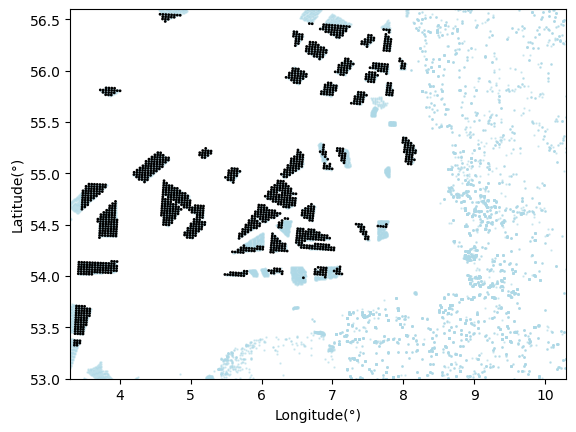

In [20]:
#Plot of the mask and turbines
directory_mask = "C:/Users/esmer/OneDrive/TN jaar 3/BEP/mask.nc"
mask = nc_read(directory_mask)
# print(mask.lon.shape)
# print(mask.lat.shape)
# print(mask.__xarray_dataarray_variable__)

directory_mask_type900901 = "C:/Users/esmer/OneDrive/TN jaar 3/BEP/mask_type900901.nc"
mask_type900901 = nc_read(directory_mask_type900901)

plt.scatter(turbines.lon,turbines.lat,s=0.5,c='lightblue',alpha=0.5)
plt.scatter(mask_type900901.lon, mask_type900901.lat, mask_type900901.__xarray_dataarray_variable__,c='k')

plt.xlabel('Longitude(°)')
plt.ylabel('Latitude(°)')
# plt.title('Check whether the mask works')
plt.xlim(3.3,10.3)
plt.ylim(53,56.6)
plt.savefig('Mask',dpi=300) #save the figure
plt.show()

# Mask voor totaal aantal windturbines op zee

In [21]:
#Read data from the coordinates of the wind turbines
turbines = read_data('E:\data\wind_turbine_coordinates_2020_2050.tab')
# turbines_filtered = turbines[turbines["type"] == 901]
turbines_filtered = turbines[turbines['type']!=999]
# turbines_filtered = turbines

#The CLT without wind turbines
directory = "E:/data/transfer_1722109_files_fe942ebb/CLT/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_CTL_ptA.20200103.1hr.nc"
data = nc_read(directory)

def bool_turbine(lowlat,highlat,leftlon,rightlon):
    windturbine = 0
    if turbines_filtered[turbines_filtered['lat'].between(lowlat, highlat) & turbines_filtered['lon'].between(leftlon, rightlon)].shape[0] > 0:
        return 1
    return 0

#The data for the mask
turbinemask = np.zeros(data.lat.values.shape)
for i in range(int(data.lat.values.shape[0])): #The y value of lon and lat
    for j in range(int(data.lat.values.shape[1])): #The x value of lon and lat
        leftlon = data.lon.values[i][j] - (1250/6371229.0)*(180/np.pi)/np.cos(data.lat.values[i][j]*(np.pi/180)) #Left boundary of longitude
        rightlon = data.lon.values[i][j] + (1250/6371229.0)*(180/np.pi)/np.cos(data.lat.values[i][j]*(np.pi/180)) #Right boundary of longitude
        lowlat = data.lat.values[i][j] - (1250/6371229.0)*(180/np.pi) #Lower boundary of latitude
        highlat = data.lat.values[i][j] + (1250/6371229.0)*(180/np.pi) #Higher boundary of latitude
        windturbine = bool_turbine(lowlat,highlat,leftlon,rightlon)
        turbinemask[i][j] = windturbine
        
#The xarray mask
masksea = xr.DataArray(
    turbinemask,
    coords={"lon": (["y", "x"], data.lon.values), "lat": (["y", "x"], data.lat.values)},
    dims = ["y", "x"]
)

masksea

<xarray.DataArray (y: 146, x: 166)>
array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lon      (y, x) float32 3.358 3.396 3.433 3.471 ... 10.17 10.21 10.25 10.29
    lat      (y, x) float32 53.33 53.33 53.32 53.32 ... 56.23 56.23 56.23 56.22
Dimensions without coordinates: y, x

In [26]:
np.sum(masksea.values)

2871.0

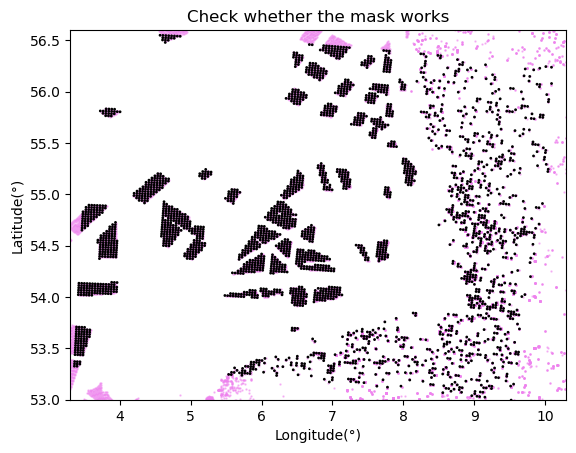

In [23]:
#Plot of the mask and turbines
plt.scatter(turbines.lon,turbines.lat,s=0.5,c='violet',alpha=0.5)
plt.scatter(masksea.lon, masksea.lat, masksea.values,c='k')
plt.xlabel('Longitude(°)')
plt.ylabel('Latitude(°)')
plt.title('Check whether the mask works')
plt.xlim(3.3,10.3)
plt.ylim(53,56.6)
#plt.savefig('Mask',dpi=300) #save the figure
plt.show()

In [73]:
#Save the xarray to netCDF
masksea.to_netcdf("masksea.nc")

In [80]:
turbines
np.min(turbines.lon.values)
turbines_filtered = turbines[turbines['lat'].between(54, 54.3) & turbines['lon'].between(3, 4.5)]

## Mask voor specifieke wind farm

In [81]:
turbines_filtered = turbines[turbines['lat'].between(54, 54.3) & turbines['lon'].between(3, 4.5)]

In [82]:
def bool_turbine(lowlat,highlat,leftlon,rightlon):
    windturbine = 0
    if turbines_filtered[turbines_filtered['lat'].between(lowlat, highlat) & turbines_filtered['lon'].between(leftlon, rightlon)].shape[0] > 0:
        return 1
    return 0

#The data for the mask
turbinemask = np.zeros(data.lat.values.shape)
for i in range(int(data.lat.values.shape[0])): #The y value of lon and lat
    for j in range(int(data.lat.values.shape[1])): #The x value of lon and lat
        leftlon = data.lon.values[i][j] - (1250/6371229.0)*(180/np.pi)/np.cos(data.lat.values[i][j]*(np.pi/180)) #Left boundary of longitude
        rightlon = data.lon.values[i][j] + (1250/6371229.0)*(180/np.pi)/np.cos(data.lat.values[i][j]*(np.pi/180)) #Right boundary of longitude
        lowlat = data.lat.values[i][j] - (1250/6371229.0)*(180/np.pi) #Lower boundary of latitude
        highlat = data.lat.values[i][j] + (1250/6371229.0)*(180/np.pi) #Higher boundary of latitude
        windturbine = bool_turbine(lowlat,highlat,leftlon,rightlon)
        turbinemask[i][j] = windturbine
        
#The xarray mask
maskwindfarm = xr.DataArray(
    turbinemask,
    coords={"lon": (["y", "x"], data.lon.values), "lat": (["y", "x"], data.lat.values)},
    dims = ["y", "x"]
)

maskwindfarm

<xarray.DataArray (y: 146, x: 166)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lon      (y, x) float32 3.358 3.396 3.433 3.471 ... 10.17 10.21 10.25 10.29
    lat      (y, x) float32 53.33 53.33 53.32 53.32 ... 56.23 56.23 56.23 56.22
Dimensions without coordinates: y, x

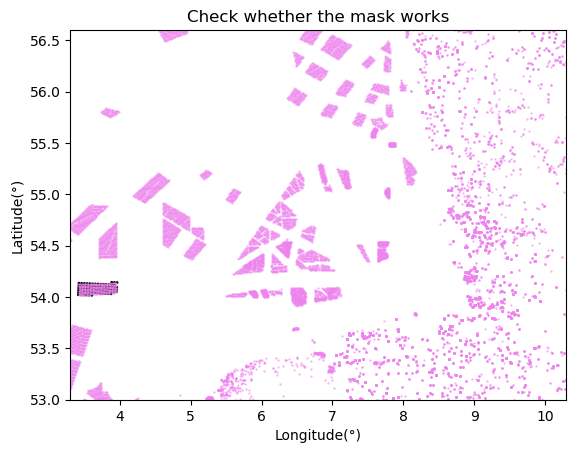

In [83]:
#Plot of the mask and turbines
plt.scatter(maskwindfarm.lon, maskwindfarm.lat, maskwindfarm.values,c='k')
plt.scatter(turbines.lon,turbines.lat,s=0.5,c='violet',alpha=0.5)
plt.xlabel('Longitude(°)')
plt.ylabel('Latitude(°)')
plt.title('Check whether the mask works')
plt.xlim(3.3,10.3)
plt.ylim(53,56.6)
#plt.savefig('Mask',dpi=300) #save the figure
plt.show()

In [84]:
#Save the xarray to netCDF
maskwindfarm.to_netcdf("maskwindfarm.nc")